# 12. 직접 만들어보는 OCR

**Text recognition 모델을 구현, 학습하고 Text detection 모델과 연결하여 OCR을 구현한다.**

## 12-9. 프로젝트: End-to-End OCR

---

### 목차
- keras-ocr의 Detector 사용
- Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보기

---

### 라이브러리

In [1]:
import re
import six
import math
import lmdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

import keras_ocr

### 데이터셋

- 다운로드한 MJ 데이터셋 위치
    - 사용할 데이터셋 [MJSynth](http://www.robots.ox.ac.uk/~vgg/data/text/)
    - Recognition model의 정량적인 평가를 위해서 MJSynth와 [SynthText](http://www.robots.ox.ac.uk/~vgg/data/scenetext/)라는 데이터셋 활용

In [2]:
BATCH_SIZE = 128
DATA_DIR = 'ocr/data'

# MJ 데이터셋 위치
TRAIN_DATA_PATH = os.path.join(DATA_DIR, 'MJ/MJ_train')
VALID_DATA_PATH = os.path.join(DATA_DIR, 'MJ/MJ_valid')
TEST_DATA_PATH = os.path.join(DATA_DIR, 'MJ/MJ_test')

- lmdb를 통해 훈련데이터셋 이미지 4개 확인(shape, 이미지, 라벨)
    - LMDB: Symas에서 만든 Lightning Memory-Mapped Database 의 약자
    - 이미지
        - height 32
        - width 는 문자열 길이에 따라 다양함

━━━━━━━━ 1 ━━━━━━━━
original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


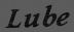

━━━━━━━━ 2 ━━━━━━━━
original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


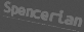

━━━━━━━━ 3 ━━━━━━━━
original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


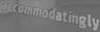

━━━━━━━━ 4 ━━━━━━━━
original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


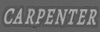

In [3]:
# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        print(f"━━━━━━━━ {index} ━━━━━━━━")
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

- MJSynth 데이터셋 클래스
    - lmdb를 활용한 케라스 모델 학습용 데이터셋 클래스 구현
    - _get_img_label()
        - 이미지 데이터를 img, label 의 쌍으로 가져오는 메서드
        - => 다양한 사이즈의 이미지를 모두 height 는 32, width 는 최대 100 이 되도록 가공
    - \_\_getitem__()
        - 배치 단위만큼 _get_img_label()을 통해 가져온 데이터셋 리턴
        - 1. idx에 해당하는 index_list만큼 데이터 불러오기
        - 2. image와 label을 불러오기
        - 3. 사용하기 좋은 inputs과 outputs형태로 반환

In [4]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                dataset_path,
                label_converter,
                batch_size=1,
                img_size=(100,32),
                max_text_len=22,
                is_train=False,
                character='') :
        
        self.label_converter = label_converter  # 문자를 미리 정의된 index로 변환해주는 converter
        self.batch_size = batch_size  # 배치 사이즈
        self.img_size = img_size  # 입력 이미지 크기
        self.max_text_len = max_text_len  # 최대 글자 수
        self.character = character  # 학습 대상으로 한정하기 위한 character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다

    # - 이미지 데이터를 img, label 의 쌍으로 가져오는 메서드
    # => 다양한 사이즈의 이미지를 모두 height 는 32, width 는 최대 100 이 되도록 가공
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__

    # - model.fit() 에서 호출되는 메서드: 배치 단위만큼 _get_img_label()을 통해 가져온 데이터셋 리턴
    def __getitem__(self, idx):
        # 1. idx에 해당하는 index_list만큼 데이터를 불러
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2. image와 label을 불러오고 
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


- LabelConverter 클래스
    - \_\_init__()
        - 입력으로 받은 text를 self.dict 에 각 character 들이 어떤 index 에 매핑되는지 저장
       - => character, index 를 통해 모델이 학습할 수 있는 output 이 생성됨
    - encode()
        - character -> index 변환
        - cf. 공백 문자를 뜻하는 '-' 의 label 은 0 으로 지정
        - 같은 문자 사이에 공백(blank) 문자 label을 삽입
    - decode()
        - index -> character 변환
        - => 사람이 읽을 수 있는 text 로 변경

In [5]:
class LabelConverter(object):

    # 입력으로 받은 text를 self.dict 에 각 character 들이 어떤 index 에 매핑되는지 저장
    # => character, index 를 통해 모델이 학습할 수 있는 output 이 생성됨
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    # character -> index 변환
    # cf. 공백 문자를 뜻하는 '-' 의 label 은 0 으로 지정
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백(blank) 문자 label을 삽입
            encoded_label.append(self.label_map[char])

        return np.array(encoded_label)

    # index -> character 변환
    # => 사람이 읽을 수 있는 text 로 변경
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

- 영문 대문자와 숫자를 인식하기 위해서 필요한 Class 개수: 36
    - 문자가 없는 경우 공백 추가해야 하므로 37개

In [6]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")  # 36

The total number of characters is 36


- 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인
    - 동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자('-')가 포함됨

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)  # [ 8  5 12  0 12 15]
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)  # HEL-LO

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


- MJDatasetSequence 로 데이터셋 분리

In [8]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

print(f'Train DataSet 개수: {len(train_set)}')  # 565
print(f'Valid DataSet 개수: {len(val_set)}')  # 63
print(f'Test DataSet 개수: {len(test_set)}')  # 70

Train DataSet 개수: 565
Valid DataSet 개수: 63
Test DataSet 개수: 70


### Text Recognition Model: CTC 학습 CRNN Model

- CTC Loss 함수
    - ![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-6-P-example.png)
        - Keras 제공 K.ctc_batch_cost() 사용 (samples == batch_size)
            - y_true: tensor (samples, max_string_length) containing the truth labels.
                - 실제 라벨 LUBE. 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
            - y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
                - 우리가 만들 RCNN 모델의 출력 결과. 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
            - input_length tensor: (samples, 1) containing the sequence length for each batch item in y_pred.
                - 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 74
            - label_length tensor: (samples, 1) containing the sequence length for each batch item in y_true.
                - 라벨의 실제 정답 길이 U로서, 이 경우에는 4
    - ![](https://d3s0tskafalll9.cloudfront.net/media/original_images/ctc.png)
        - 입력 길이 T != 라벨 길이 U 일 경우
            - 라벨 APPLE, 모델 출력 결과 AAAPPPPLLLLEE => 추론 결과: APLE
            - 라벨 AP-PLE 보정, 모델 출력 결과 AAAPPPPLLLLEE => 추론 결과: APPLE
                - 라벨 보정: LabelConverter.encode() 메서드에 공백문자 처리 로직이 포함됨

In [9]:
# CTC loss를 계산하기 위한 Lambda 함수
def ctc_lambda_func(args):
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


- Recognition Model
    - CRNN 구조<br>![](https://d3s0tskafalll9.cloudfront.net/media/original_images/e-23-3.crnn_structure.png)
    - CTC Loss
    - 이미지 입력 레이어: input_image
    - 라벨 출력 레이어: output

In [10]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    # Conv Layers
    # Feature 추출
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)

    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)

    # Recurrent Layers
    # 추출된 Feature 의 전체적인 Context 파악
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)

    # Transcription Layer(=Fully Connected Layer)
    # Step 마다 어떤 Character 의 확률이 높은지 예측
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    # CRNN 모델 생성
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(inputs=model_input, outputs=loss_out)
    return model

- 모델 생성

In [11]:
model = build_crnn_model()

- 모델 구조

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 32, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 32, 64)  1792        ['input_image[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 50, 16, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 50, 16, 128)  73856       ['max_pooling2d[0][0]']      

- 모델 구조 시각화

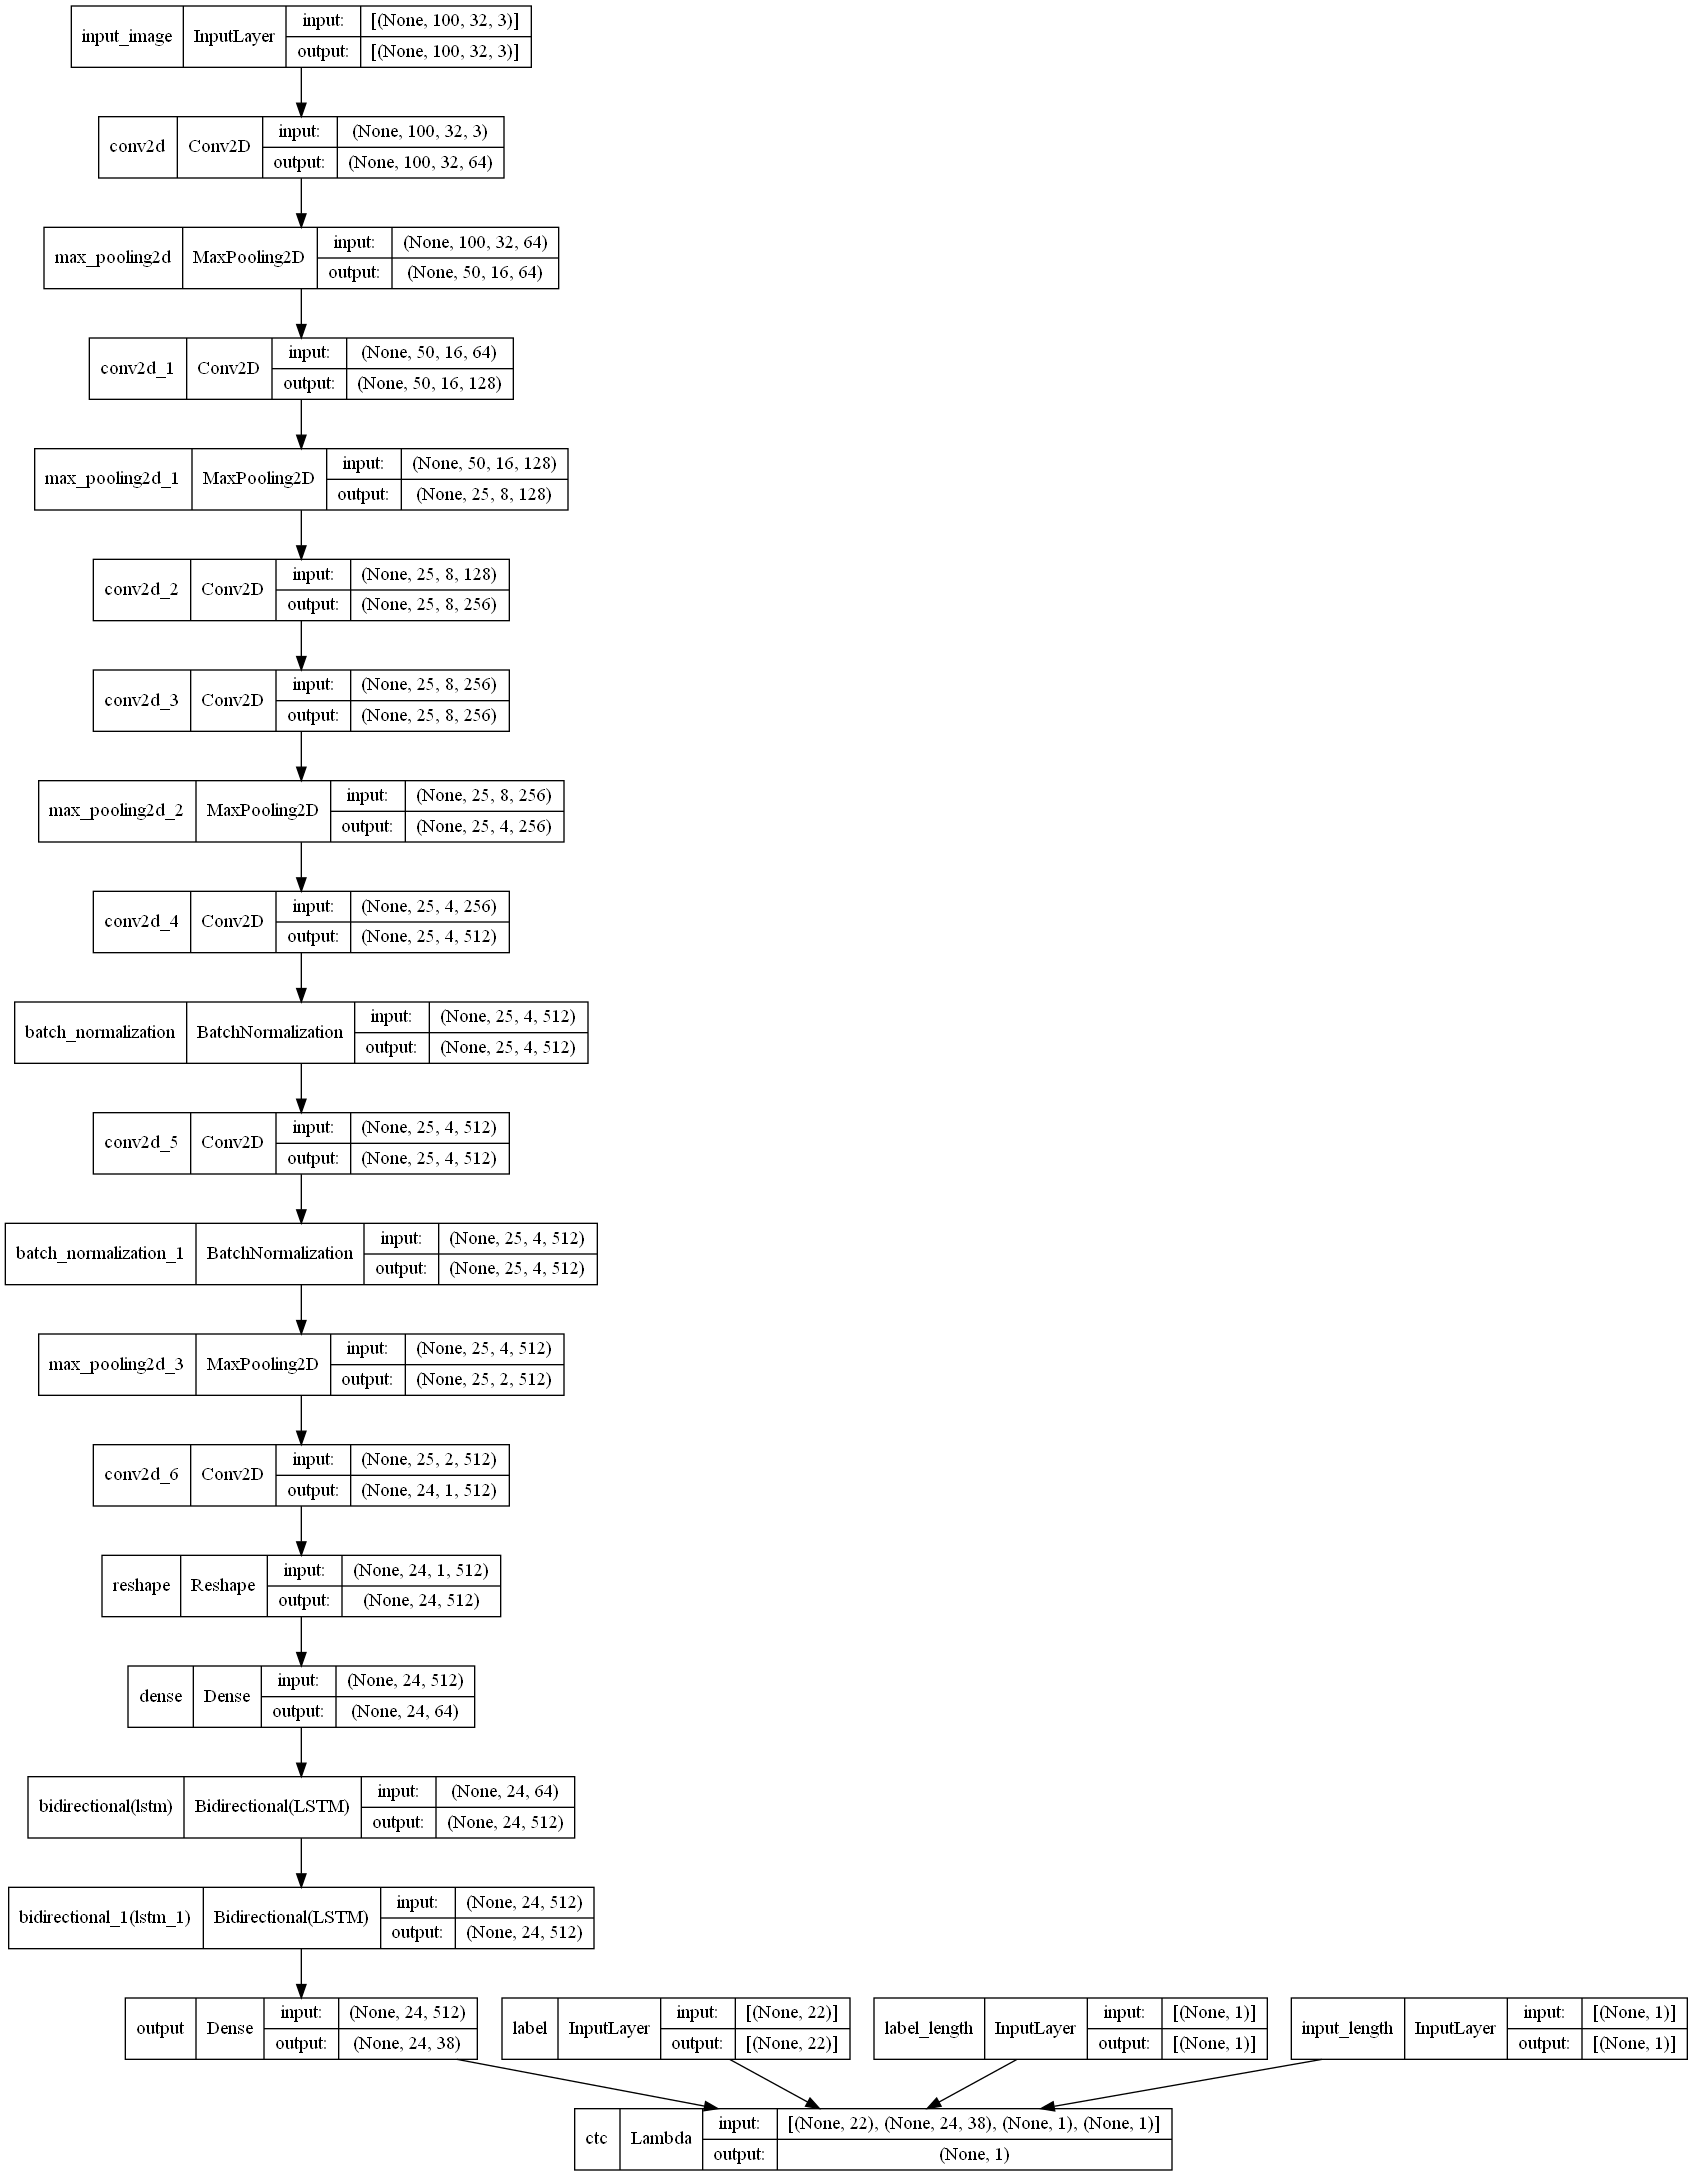

In [13]:
plot_model(model, to_file=f'result/Recognition_CRNN_shapes.png', show_shapes=True)

- 모델 훈련 및 저장

In [14]:
# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(
    optimizer=optimizer,
    loss={'ctc': lambda y_true, y_pred: y_pred},
    metrics=['accuracy'],
)

In [15]:
EPOCHS=50

In [16]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = os.path.join(DATA_DIR, f'model_checkpoint_{EPOCHS}.hdf5')
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
crnn_history = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=EPOCHS,
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[ckp, earlystop]
)

Epoch 1/50
565/565 [==============================] - ETA: 0s - loss: 25.3676 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 23.05353, saving model to ocr/data\model_checkpoint_50.hdf5
565/565 [==============================] - 129s 203ms/step - loss: 25.3676 - accuracy: 0.0000e+00 - val_loss: 23.0535 - val_accuracy: 0.0000e+00
Epoch 2/50
565/565 [==============================] - ETA: 0s - loss: 14.4205 - accuracy: 0.0028
Epoch 00002: val_loss improved from 23.05353 to 9.33325, saving model to ocr/data\model_checkpoint_50.hdf5
565/565 [==============================] - 113s 200ms/step - loss: 14.4205 - accuracy: 0.0028 - val_loss: 9.3332 - val_accuracy: 0.0124
Epoch 3/50
565/565 [==============================] - ETA: 0s - loss: 6.9722 - accuracy: 0.0917
Epoch 00003: val_loss improved from 9.33325 to 6.63802, saving model to ocr/data\model_checkpoint_50.hdf5
565/565 [==============================] - 113s 200ms/step - loss: 6.9722 - accuracy: 0.0917 - val_loss: 6.63

- 학습 결과 시각화

In [17]:
def draw_unet_history(history, model_name='Recognition_CRNN'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.savefig(f'result/{model_name}_Result.png')  # 저장
    plt.show()

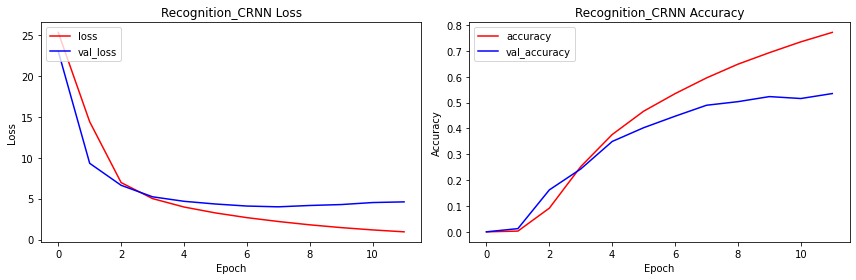

In [18]:
draw_unet_history(crnn_history, 'Recognition_CRNN')

- 저장한 모델 불러오기

In [19]:
# 다음은 20 Epochs 이상 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = os.path.join(DATA_DIR, f'model_checkpoint_{EPOCHS}.hdf5')

In [20]:
model = build_crnn_model()
model.load_weights(checkpoint_path)

- Inference 모델 생성
    - CRNN 모델 입력 중 input_image 만 사용

In [21]:
# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

- Inference 결과 확인
    - 학습된 모델의 성능을 테스트셋을 통해 확인

In [22]:
# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        # 의미없는 인덱스 -1 위치 숫자 9 출력 방지
        if index == -1:
            continue
        # 예측한 문자 저장
        text += chars[index]
    return text

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        print(f"━━━━━━━━ {i} ━━━━━━━━")
        inputs, outputs = dataset[i]
        img = inputs['input_image'][0:1,:,:,:]
        output = model.predict(img)  # 모델 예측

        # 예측
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS).replace('-','')
        print(f"Result: \t{result}")
        
        # 라벨
        label = ''.join(map(lambda x: label_converter.decode(x), inputs['label'][0:1,])).replace('-','')
        print(f"Label:  \t{label}")

        # 예측, 라벨 인덱스별로 비교해서 같으면 1, 다르면 0 표시
        is_right = ''.join(map(lambda x: '1' if x[0] == x[1] else '0', zip(result, label)))
        print(f"Is_Right:\t{is_right}")

        # 맞춘 문자 개수, 점수 계산
        is_right_count = is_right.count('1')
        print(f"Is_Right_Count:\t{is_right_count}/{len(label)}")
        print(f"Score: {is_right_count/len(label):.2f}")

        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

━━━━━━━━ 0 ━━━━━━━━
Result: 	SLINKING
Label:  	SLINKING
Is_Right:	11111111
Is_Right_Count:	8/8
Score: 1.00


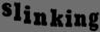

━━━━━━━━ 1 ━━━━━━━━
Result: 	ALEPPO
Label:  	ALEPPO
Is_Right:	111111
Is_Right_Count:	6/6
Score: 1.00


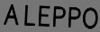

━━━━━━━━ 2 ━━━━━━━━
Result: 	RWGINDA
Label:  	RWANDA
Is_Right:	110000
Is_Right_Count:	2/6
Score: 0.33


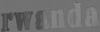

━━━━━━━━ 3 ━━━━━━━━
Result: 	NATHANS
Label:  	NATHANS
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


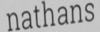

━━━━━━━━ 4 ━━━━━━━━
Result: 	HALLCO
Label:  	HALLOO
Is_Right:	111101
Is_Right_Count:	5/6
Score: 0.83


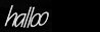

━━━━━━━━ 5 ━━━━━━━━
Result: 	HURLS
Label:  	HURLS
Is_Right:	11111
Is_Right_Count:	5/5
Score: 1.00


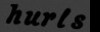

━━━━━━━━ 6 ━━━━━━━━
Result: 	DOWNSIZE
Label:  	DOWNSIZE
Is_Right:	11111111
Is_Right_Count:	8/8
Score: 1.00


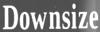

━━━━━━━━ 7 ━━━━━━━━
Result: 	ROBOTIC
Label:  	ROBOTIC
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


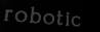

━━━━━━━━ 8 ━━━━━━━━
Result: 	SLOPPY
Label:  	SLOPPY
Is_Right:	111111
Is_Right_Count:	6/6
Score: 1.00


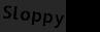

━━━━━━━━ 9 ━━━━━━━━
Result: 	HERMITE
Label:  	HERMITE
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


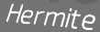

━━━━━━━━ 10 ━━━━━━━━
Result: 	DEARS
Label:  	DEARS
Is_Right:	11111
Is_Right_Count:	5/5
Score: 1.00


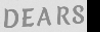

━━━━━━━━ 11 ━━━━━━━━
Result: 	POLYSYLLABIC
Label:  	POLYSYLLABIC
Is_Right:	111111111111
Is_Right_Count:	12/12
Score: 1.00


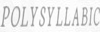

━━━━━━━━ 12 ━━━━━━━━
Result: 	DLERTAS
Label:  	DENSE
Is_Right:	10000
Is_Right_Count:	1/5
Score: 0.20


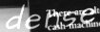

━━━━━━━━ 13 ━━━━━━━━
Result: 	DIAERESES
Label:  	DIAERESES
Is_Right:	111111111
Is_Right_Count:	9/9
Score: 1.00


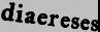

━━━━━━━━ 14 ━━━━━━━━
Result: 	HUMPBACKS
Label:  	HUMPBACKS
Is_Right:	111111111
Is_Right_Count:	9/9
Score: 1.00


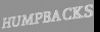

━━━━━━━━ 15 ━━━━━━━━
Result: 	SDOPTED
Label:  	ADOPTED
Is_Right:	0111111
Is_Right_Count:	6/7
Score: 0.86


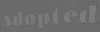

━━━━━━━━ 16 ━━━━━━━━
Result: 	MILWVAUKEE
Label:  	MILWAUKEE
Is_Right:	111100001
Is_Right_Count:	5/9
Score: 0.56


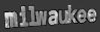

━━━━━━━━ 17 ━━━━━━━━
Result: 	SPECIFICATION
Label:  	SPECIFICATION
Is_Right:	1111111111111
Is_Right_Count:	13/13
Score: 1.00


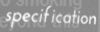

━━━━━━━━ 18 ━━━━━━━━
Result: 	PREACTIONARY
Label:  	REACTIONARY
Is_Right:	00000000000
Is_Right_Count:	0/11
Score: 0.00


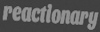

━━━━━━━━ 19 ━━━━━━━━
Result: 	OSCEOLA
Label:  	OSCEOLA
Is_Right:	1111111
Is_Right_Count:	7/7
Score: 1.00


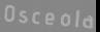

In [23]:
check_inference(model_pred, test_set, index=20)

---

### End-to-End OCR

- Text Detection 수행 함수
    - 이미지 경로를 받아 해당 이미지 내의 문자 찾아내기
        - **Keras-OCR 의 Detector 사용**
        - inference 후 시각화
        - 단어 영역 잘라내기

In [30]:
def detect_text(img_path, detector):
    
    # 이미지 불러오기
    img_pil = Image.open(img_path).convert('RGB')  # (1200, 900, 3)

    # 1. Keras-OCR 의 Detection 모델에 입력하기 위한 이미지 전처리
    # - 이미지 비율 유지해서 resize() 적용
    # - 배치 크기 때문에 4 dims 로 확장
    # - shape=(H,W,C) 여야 모델 입력시 제대로 동작함
    width, height = img_pil.size  # 원본 이미지 크기
    target_width = min(int(width*300/height), 400)  # 이미지 비율 유지, 높이 300, 너비는 400 보다 작게 설정
    target_img_size = (target_width,300)

    # img_pil = img_pil.resize(target_img_size)  # (400, 300, 3)
    img_pil_copy = img_pil.copy()

    img_pil = np.array(img_pil)  # (300, 400, 3)
    img_pil = np.expand_dims(img_pil, axis=0)  # (1, 300, 400, 3)
    
    # 2. 모델 예측
    # - OCR 텍스트 검출 결과
    # - 배치 첫 번째 결과 가져오기
    detect_result = detector.detect(img_pil)  # 타입: list
    ocr_result = detect_result[0]  # 타입: np.array
	
    # 3. display() 하기 위한 이미지 전처리
    # - 앞서 4 dims 로 확장시켰으므로 다시 3 dims 가 되도록 축소
    # - shape=(H,W,C) 여야 display() 에서 이미지가 제대로 그려짐
    img_pil = np.squeeze(img_pil, axis=0).astype(np.uint8)  # (300, 400, 3)
    img_pil = Image.fromarray(img_pil)
    img_draw = ImageDraw.Draw(img_pil)

    cropped_imgs = []  # 단어 영역
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil_copy.crop(word_box))
    
    return img_pil, cropped_imgs

- Text Recognition 수행 함수
    - 잘려진 단어 이미지 인식
        - 단어 영역 시각화
        - 앞서 구현한 CTC 학습 CRNN Model 사용
        - 인식한 문자 출력

In [25]:
def recognize_img(idx, pil_img, model_pred, input_img_size=(100,32)):
    # CRNN 기반의 Recognition 모델에 입력하기 위한 이미지 전처리
    # - 배치 크기 때문에 4 dims 로 확장
    # - shape=(W,H,C) 여야 모델 입력시 제대로 동작함
    pil_img = pil_img.resize(input_img_size)  # (100, 32, 3)
    pil_img = np.array(pil_img)  # (32, 100, 3)
    pil_img = pil_img.transpose(1,0,2)  # (100, 32, 3)
    pil_img = np.expand_dims(pil_img, axis=0)  # (1, 100, 32, 3)
    
    # 모델 예측
    # - OCR 텍스트 인식 결과 출력
    output = model_pred.predict(pil_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS).replace('-','')
    print("Result: \t", result)
    
    # display() 하기 위한 이미지 전처리
    # - 앞서 4 dims 로 확장시켰으므로 다시 3 dims 가 되도록 축소
    # - shape=(H,W,C) 여야 display() 에서 이미지가 제대로 그려짐
    pil_img = np.squeeze(pil_img, axis=0).transpose(1,0,2).astype(np.uint8)  # (32, 100, 3)
    pil_img = Image.fromarray(pil_img)
    pil_img.save(f'result/Text_Recognition_{idx}.png')  # 저장
    display(pil_img)

- End-to-End OCR 수행 함수
    - keras-ocr detector
    - CRNN recognizer

In [26]:
def end_to_end_ocr(img_path, detector, model_pred):
    # Text Detection
    print('━━━━━━━━ Text Detection ━━━━━━━━')
    img_pil, cropped_img = detect_text(img_path, detector)
    img_pil.save(f'result/sample.png')  # 저장
    display(img_pil)

    # Text Recognition
    print('━━━━━━━━ Text Recognition ━━━━━━━━')
    for idx, _img in enumerate(cropped_img):
        recognize_img(idx, _img, model_pred)

- End-to-End OCR 결과 확인

In [27]:
SAMPLE_IMG_PATH = os.path.join(DATA_DIR, 'sample.jpg')

In [28]:
detector = keras_ocr.detection.Detector()

Looking for C:\Users\User\.keras-ocr\craft_mlt_25k.h5


━━━━━━━━ Text Detection ━━━━━━━━


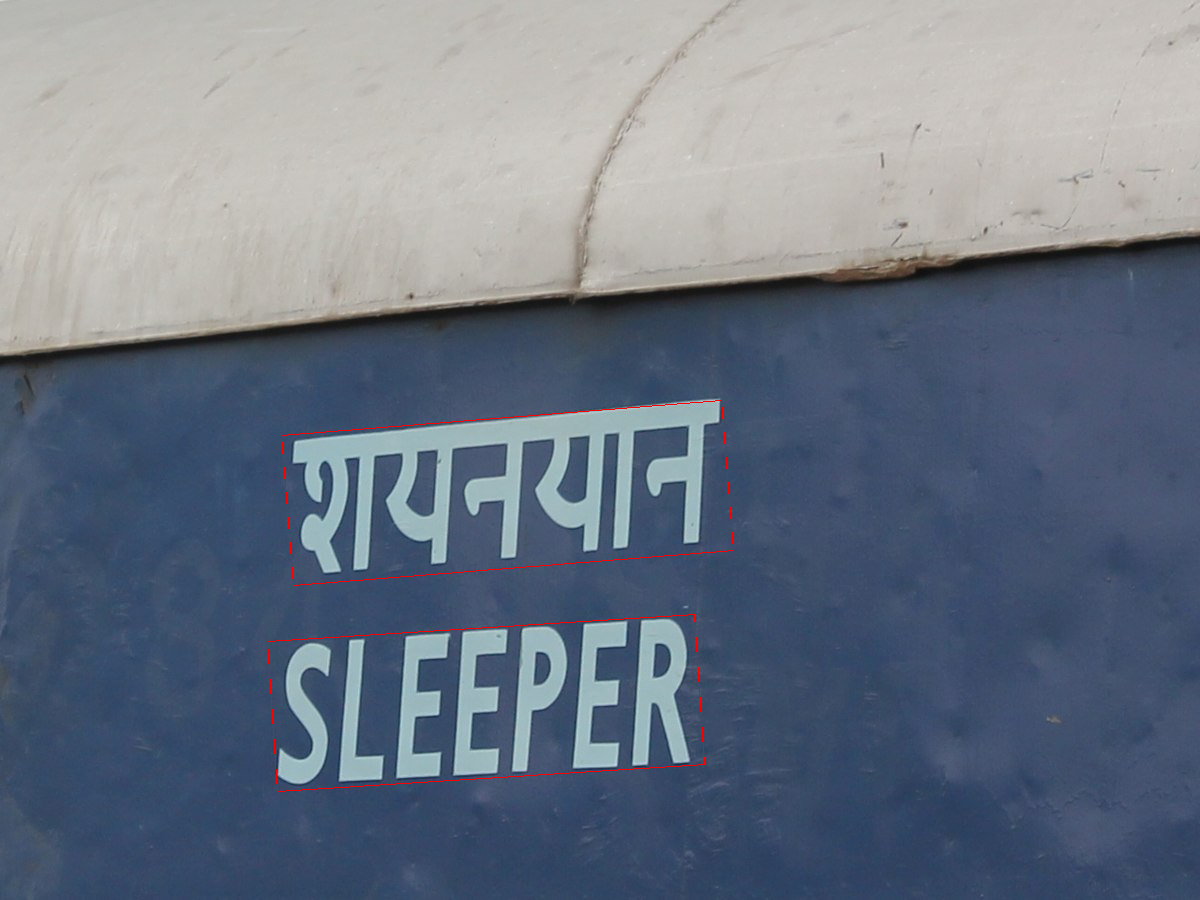

━━━━━━━━ Text Recognition ━━━━━━━━
Result: 	 RTRARI


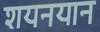

Result: 	 SLEEPER


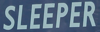

In [31]:
end_to_end_ocr(SAMPLE_IMG_PATH, detector, model_pred)

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
detect_text() 함수를 구현할 때 이미지를 리사이징을 안 하면 keras_ocr.detection.Detector().detect() 가 제대로 동작하지만 리사이징을 하면 `error: Unknown C++ exception from OpenCV code` 에러가 계속 발생했다. 내 잘못인가 싶어서 이 부분에서 스트레스를 너무 많이 받았다. 여러 번 재차 실행하다 에러 없이 돌아갈 때가 있는 걸 보면 코드의 문제는 아니고 C++ 과 파이썬 호환성 문제인 것 같다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 헷갈렸던 부분
    - np.array(pil_img)
        - PIL 이미지 객체를 numpy 로 변환하면 shape 가 (W,H,C) 에서 자동으로 (H,W,C) 로 변한다.
    - Image.fromarray(np_img)
        - numpy 객체를 PIL 이미지 객체로 변환하면 shape 가 (H,W,C) 에서 자동으로 (W,H,C) 로 변한다.
- (W,H,C) -> (H,W,C) 변경하는 방법
    - np_img = np_img.transpose(1,0,2)
- 차원 확장/축소 방법
    - 확장
        - np_img = np.reshape((1,) + np_img.shape)
        - np_img = np.expand_dims(np_img, axis=0)
        - np_img = np_img[np.newaxis, :, :, :]
    - 축소
        - np_img = np.squeeze(np_img, axis=0)
- OCR(Optical character recognition)
    - 사람이 쓰거나 기계로 인쇄한 문자의 영상을 이미지 스캐너로 획득하여 기계가 읽을 수 있는 문자로 변환하는 것
    - 이미지 속에서 영문을 Bounding box로 찾고, B-box 내 어떤 text가 포함되는지 알 수 있는 시스템
- Keras-OCR [[깃허브 코드]](https://github.com/faustomorales/keras-ocr) [[Doc]](https://keras-ocr.readthedocs.io/en/latest/) [[사용 예제]](https://keras.io/examples/vision/captcha_ocr/)
    - CRAFT 텍스트 감지(Detection) 모델 + CTC로 학습된 CRNN 인식(Recognition) 모델 패키지된 버전
        - detector = keras_ocr.detection.Detector()
        - recognizer = keras_ocr.recognition.Recognizer()
    - 텍스트 감지 및 OCR 파이프라인 교육을 위한 고급 API 제공

### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.|텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.|
>|2|CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.|학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.|
>|3|keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.|샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.|

Text recognition 을 위해 이미지 데이터셋 MJSynth 을 불러와서 resize, encode, batch 처리를 수행했다.

CRNN + CTC Loss 로 Recognition 모델을 구현했고 val_loss 를 기준으로 early stopping 을 설정해서 초과 학습을 막았다. 데이터셋의 라벨, 맞춘 글자 개수, 점수를 산출하는 코드를 추가해보았다. Inference 결과와 라벨을 비교해 보면 대부분 모두 정확히 맞췄고 어쩌다 문자 한 두개를 틀리는 정도의 높은 정확도를 보였다.

keras-ocr detector 함수와 CRNN recognizer 함수를 사용하는 End-to-End OCR 함수를 만들었다. OCR 수행 결과를 보면 영어는 확실하게 제대로 검출(Detection) 및 인식(Recognition)하는 것을 볼 수 있다.


### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
Keras-OCR 의 detector 모델(vgg 기반의 CRAFT 구조) 또한 같이 살펴볼 수 있으면 좋았을 것 같다.